In [1]:
import sys
sys.path.insert(0, '$ATHENA_DIR/vis/python')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
from scipy.interpolate import griddata

# Athena++ modules
import athena_read
import h5py

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
filename = 'disk.out1.00093.athdf'

In [4]:
def MidplaneCut(filename):

# Read attributes and data
  f=h5py.File(filename, 'r')
  level = f.attrs['MaxLevel']
  block_size = f.attrs['MeshBlockSize']
  root_grid_size = f.attrs['RootGridSize']
  levels = f['Levels'][:]
  logical_locations = f['LogicalLocations'][:]
  nx1 = root_grid_size[0] * 2**level
  nx2 = root_grid_size[1] * 2**level if root_grid_size[1] > 1 else 1
  nx3 = root_grid_size[2] * 2**level if root_grid_size[2] > 1 else 1

  if nx3 > 1:
    dim = 3
  elif nx2 > 1:
    dim = 2
  else:
    dim = 1

  data={}

# the coordinates
  for d in range(1,4):
    nx = (nx1,nx2,nx3)[d-1]
    xmin = f.attrs['RootGridX'+repr(d)][0]
    xmax = f.attrs['RootGridX'+repr(d)][1]
    xrat_root = f.attrs['RootGridX'+repr(d)][2]
    if (xrat_root == 1.0):
      data['x'+repr(d)+'f'] = np.linspace(xmin, xmax, nx+1)
    else:
      xrat = xrat_root ** (1.0 / 2**level)
      data['x'+repr(d)+'f'] = \
         xmin + (1.0-xrat**np.arange(nx+1)) / (1.0-xrat**nx) * (xmax-xmin)


  var_quantities = np.array([x.decode('ascii', 'replace') for x in f.attrs['VariableNames'][:]])
  coord_quantities = ('x1f', 'x2f', 'x3f', 'x1v', 'x2v', 'x3v')
  attr_quantities = [key for key in f.attrs]
  other_quantities = ('Levels',)    
  quantities = var_quantities
  quantities = [str(q) for q in quantities if q not in coord_quantities 
              and q not in attr_quantities and q not in other_quantities]
  for key in attr_quantities:
    data[str(key)] = f.attrs[key]
  num_blocks = f.attrs['NumMeshBlocks']
  dataset_names = np.array([x.decode('ascii', 'replace')
                                  for x in f.attrs['DatasetNames'][:]])
  dataset_sizes = f.attrs['NumVariables'][:]
  dataset_sizes_cumulative = np.cumsum(dataset_sizes)
  variable_names = np.array([x.decode('ascii', 'replace')
                                   for x in f.attrs['VariableNames'][:]])
  quantity_datasets = []
  quantity_indices = []
  spec_datasets = []
  spec_indices = []
  for q in quantities:
    var_num = np.where(variable_names == q)[0][0]
    dataset_num = np.where(dataset_sizes_cumulative > var_num)[0][0]
    if dataset_num == 0:
          dataset_index = var_num
    else:
          dataset_index = var_num - dataset_sizes_cumulative[dataset_num-1]
    quantity_datasets.append(dataset_names[dataset_num])
    quantity_indices.append(dataset_index)
    if q == 'rho' or q=='vel1' or q=='vel2' or q=='vel3' or q=='press' or q=='Bcc1' or \
                q=='Bcc2' or q=='Bcc3' or q=='Er' or q=='Sigma_s_0' or q=='Sigma_a_0' or q=='Fr01' or q=='Fr02' \
                or q == 'Fr03' or q == 'Er0':
      spec_datasets.append(dataset_names[dataset_num])
      spec_indices.append(dataset_index)



  n_rmax=nx1
  for q in quantities:
    data[q] = np.zeros((nx3,n_rmax))
  vol_phi=np.zeros((nx2,n_rmax))

  # print(f['x2f'])


# Go through blocks in data file
  for block_num in range(num_blocks):
    # if np.any(np.isclose(f['x2f'][block_num],0.5*np.pi)):
      if 0.5*np.pi > min(f['x2f'][block_num]) and 0.5*np.pi < max(f['x2f'][block_num]):
        # Extract location information
        block_level = levels[block_num]
        block_location = logical_locations[block_num,:]
      # Calculate scale (number of copies per dimension)
        s= 2**(level-block_level)
      
      # the block size
        block_phi_size=f['x3f'][block_num][block_size[2]]-f['x3f'][block_num][0]
        radius=f['x1f'][block_num]
        theta=f['x2f'][block_num]
        phi=f['x3f'][block_num]

        # print(theta)



        # get cell center coordinates
        x1v=np.zeros(block_size[0])
        x2v=np.zeros(block_size[1])
        x3v=np.zeros(block_size[2])
    
        for ni in range(block_size[0]):
          x1v[ni]=0.75*(radius[ni+1]**4.0 - radius[ni]**4.0)/(radius[ni+1]**3.0-radius[ni]**3.0);

        for nj in range(block_size[1]):
          x2v[nj]=((np.sin(theta[nj+1]) - theta[nj+1] * np.cos(theta[nj+1])) \
              -(np.sin(theta[nj]) - theta[nj] * np.cos(theta[nj]))) \
                  / (np.cos(theta[nj]) - np.cos(theta[nj+1]))

        for nk in range(block_size[2]):
          x3v[nk] = 0.5 * (phi[nk+1]+phi[nk])
      
        grid_phi,grid_r=np.meshgrid(x3v,x1v,indexing='ij')
  

    # Calculate fine-level begin indices
        il = block_location[0] * block_size[0] * s
        kl = block_location[2] * block_size[2] * s if dim >= 2 else 0

    # Calculate fine-level end indices
        iu = il + block_size[0] * s
        ku = kl + block_size[2] * s if dim >= 2 else 1

    # Calculate fine-level offsets
        io_vals = range(s)
        ko_vals = range(s) if dim >= 2 else (0,)

              
        rho_data=f[spec_datasets[0]][spec_indices[0],block_num,:]
        vr_data=f[spec_datasets[2]][spec_indices[2],block_num,:]

        for ko in ko_vals:
          for io in io_vals:
              vol_phi[kl+ko:ku+ko:s,il+io:iu+io:s] \
                  = vol_phi[kl+ko:ku+ko:s,il+io:iu+io:s] + block_phi_size


      # Assign values
        for q,dataset,index in zip(quantities,quantity_datasets,quantity_indices):
          oridata=f[dataset][index,block_num,:]
          # print(oridata.shape)

          # find the position corresponding to phiplot position
          rmax = max(radius)
          thetapos=np.abs(x2v-0.5*np.pi).argmin()
          rmaxpos=np.abs(x1v-rmax).argmin()


          # print(ko_vals)
          for ko in ko_vals:
            for io in io_vals:
              data[q][kl+ko:ku+ko:s,il+io:iu+io:s] = oridata[:,thetapos,:]
              # print(data[q][kl+ko:ku+ko:s,il+io:iu+io:s].shape)
        


        # divide by the total phi volume

        for q in quantities:
            data[q][:,:] = np.nan_to_num(data[q][:,:])


      # get the cell center coordinates
        # get cell center coordinates
        data['x1v']=np.zeros(nx1)
        data['x3v']=np.zeros(nx3)
    
        for ni in range(nx1):
          data['x1v'][ni]=0.75*(data['x1f'][ni+1]**4.0 - data['x1f'][ni]**4.0)/(data['x1f'][ni+1]**3.0-data['x1f'][ni]**3.0);
        
        for nk in range(nx3):
          data['x3v'][nk]=0.5 * (data['x3f'][nk+1]+data['x3f'][nk]);

        #add time
        data['Time']=f.attrs['Time']
        data['quantities']=quantities
  f.close()

  return data




In [5]:
def get_quantities(func):

	data = func(filename)

	rho = data['rho']
	press = data['press']
	velr = data['vel1']
	veltheta = data['vel2']
	velphi = data['vel3']

	x1f = data['x1f']
	x2f = data['x2f']
	x3f = data['x3f']

	# x1v = data['x1v']
	# x2v = data['x2v']
	# x3v = data['x3v']

	time = data['Time']

	quantities = {
		"x1f": {"quantity": x1f, "name": 'radius'},
		"x2f": {"quantity": x2f, "name": 'theta'},
		"x3f": {"quantity": x3f, "name": 'phi'},
		# "x1v": {"quantity": x1v, "name": 'radius'},
		# "x2v": {"quantity": x2v, "name": 'theta'},
		# "x3v": {"quantity": x3v, "name": 'phi'},
		"time": {"quantity": time, "name": "time"},
	    "rho": {"quantity": rho, "name": 'Density', "norm": matplotlib.colors.LogNorm()},
	    "velr": {"quantity": velr, "name": 'Radial velocity', "norm": matplotlib.colors.Normalize(vmin=min(velr[0]), vmax=max(velr[0]))},
	    "velphi": {"quantity": velphi, "name": 'Azimuthal velocity', "norm": matplotlib.colors.Normalize(vmin=min(velphi[0]), vmax=max(velphi[0]))},
		"veltheta": {"quantity": veltheta, "name": 'Azimuthal velocity', "norm": matplotlib.colors.Normalize(vmin=min(velphi[0]), vmax=max(velphi[0]))},
	    "press": {"quantity": press, "name": 'Pressure', "norm": matplotlib.colors.Normalize(vmin=min(press[0]), vmax=max(press[0]))}
	}

	return quantities

In [6]:
data_midplane = MidplaneCut(filename)

In [6]:
data_midplane['vel3'].shape

(16512, 3072)

In [7]:
data_midplane['Time']

28.902853

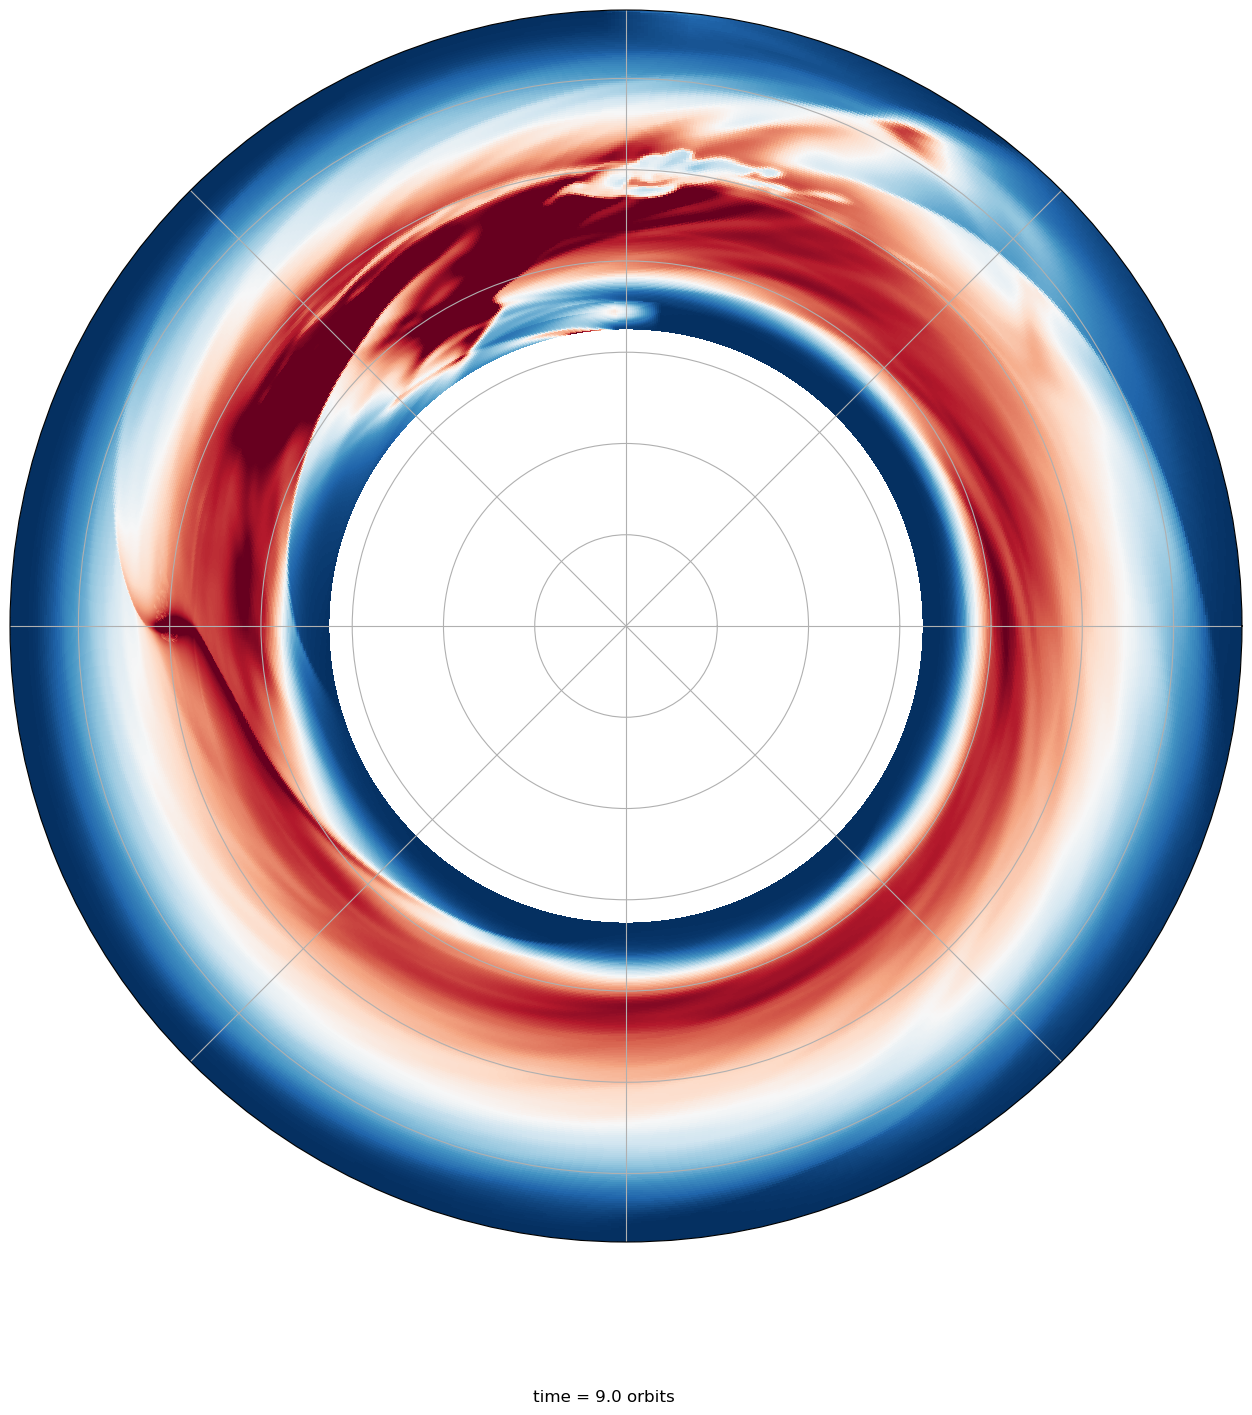

In [7]:
plots, axes = plt.subplots(figsize=(18,16),subplot_kw=dict(projection='polar'))

# ridx = np.where(data['x1f'])[0][:-1]
# thetaidx = np.where(data['x2f'])[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min(data_midplane['rho'][0]), vmax=max(data_midplane['rho'][0]))
xmesh,ymesh=np.meshgrid(data_midplane['x3f'],data_midplane['x1f'])
im=axes.pcolormesh(xmesh,ymesh,data_midplane['rho'].T,cmap='RdBu_r', norm=norm)     

U = data_midplane['vel1']
V = data_midplane['vel3']

x = np.linspace(data_midplane['x1f'][0], data_midplane['x1f'][-1],U.shape[1])#[::ratex]
y = np.linspace(data_midplane['x3f'][0], data_midplane['x3f'][-1],U.shape[0])
X,Y = np.meshgrid(x,y)
#  Varying density along a streamline
# stream = axes.streamplot(X,Y, U, V)

# cbar=plots.colorbar(im, ax=axes)
# Turn off tick labels
axes.set_yticklabels([])
axes.set_xticklabels([])

plt.figtext(0.5, 0.01, 'time = '+str(data_midplane['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
# axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

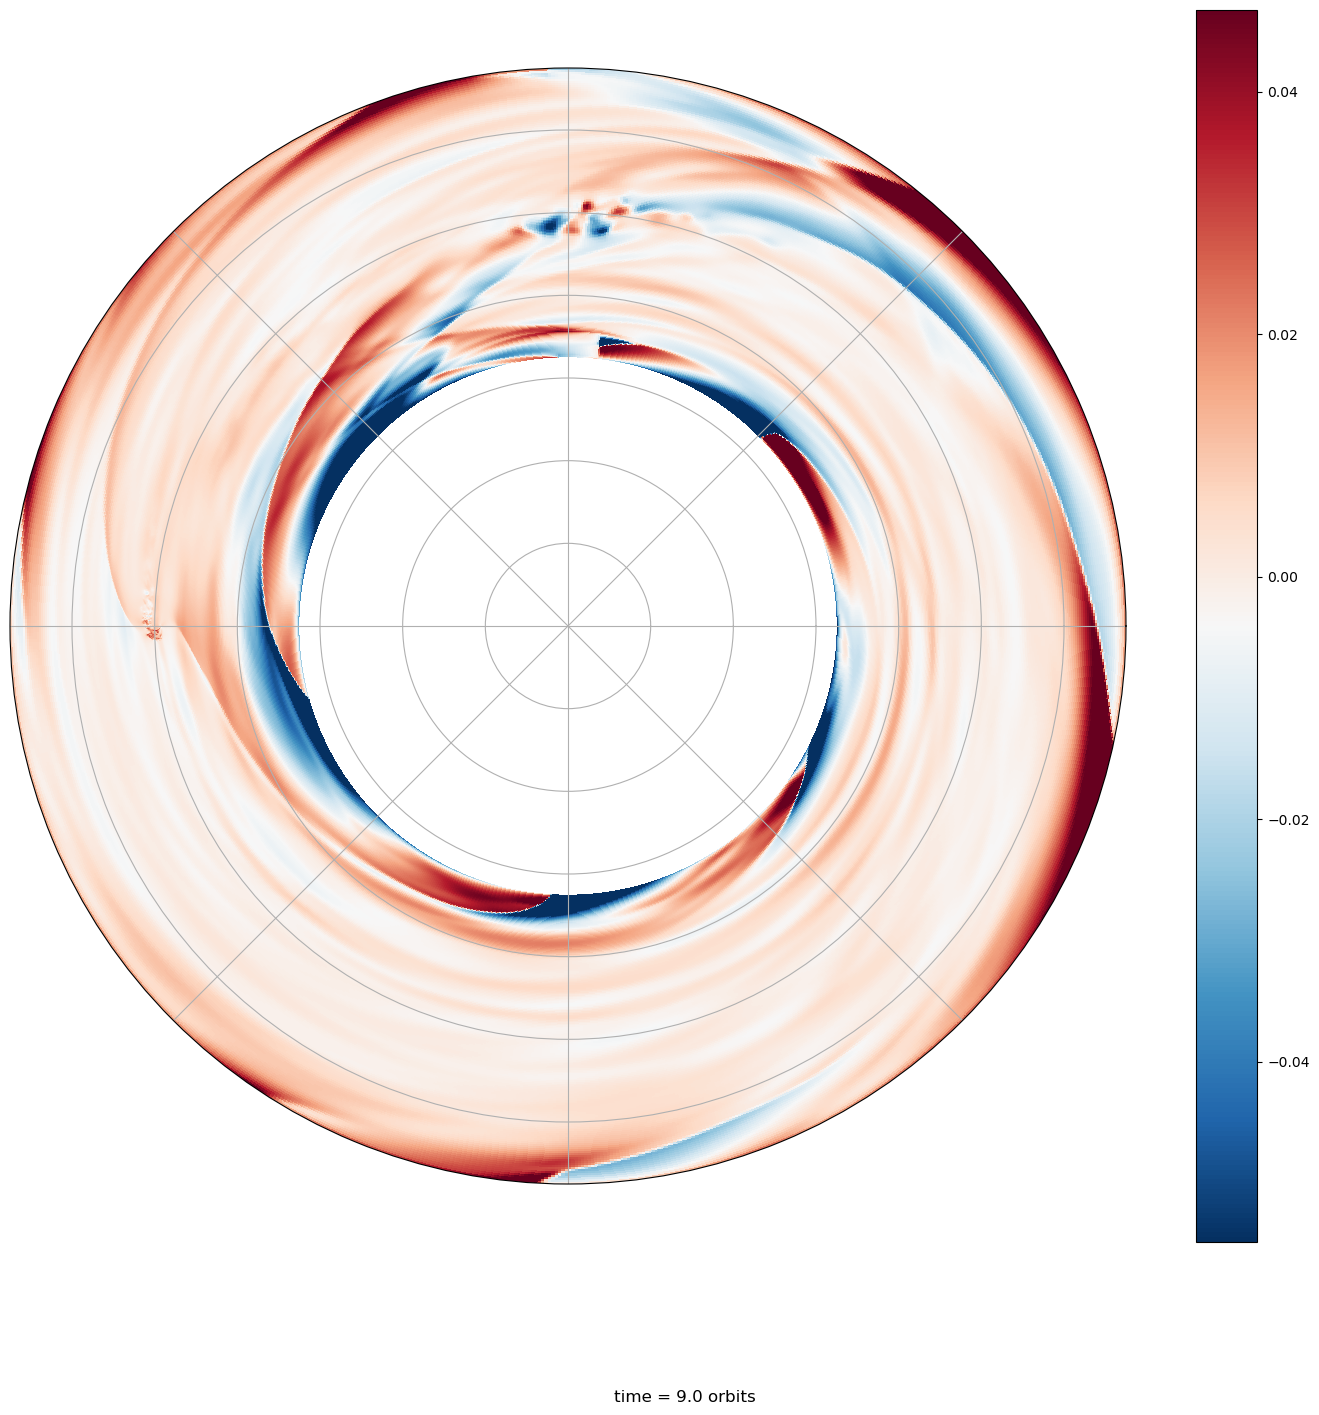

In [14]:
plots, axes = plt.subplots(figsize=(18,16),subplot_kw=dict(projection='polar'))

# ridx = np.where(data['x1f'])[0][:-1]
# thetaidx = np.where(data['x2f'])[0][:-1]

norm=matplotlib.colors.Normalize(vmin=min(data_midplane['vel1'][0]), vmax=max(data_midplane['vel1'][0]))
xmesh,ymesh=np.meshgrid(data_midplane['x3f'],data_midplane['x1f'])
im=axes.pcolormesh(xmesh,ymesh,data_midplane['vel1'].T,cmap='RdBu_r', norm=norm)    

cbar=plots.colorbar(im, ax=axes)

U = data_midplane['vel1']
V = data_midplane['vel3']

x = np.linspace(data_midplane['x1f'][0], data_midplane['x1f'][-1],U.shape[1])#[::ratex]
y = np.linspace(data_midplane['x3f'][0], data_midplane['x3f'][-1],U.shape[0])
X,Y = np.meshgrid(x,y)
#  Varying density along a streamline
# stream = axes.streamplot(X,Y, U, V)

# cbar=plots.colorbar(im, ax=axes)
# Turn off tick labels
axes.set_yticklabels([])
axes.set_xticklabels([])

plt.figtext(0.5, 0.01, 'time = '+str(data_midplane['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
# axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

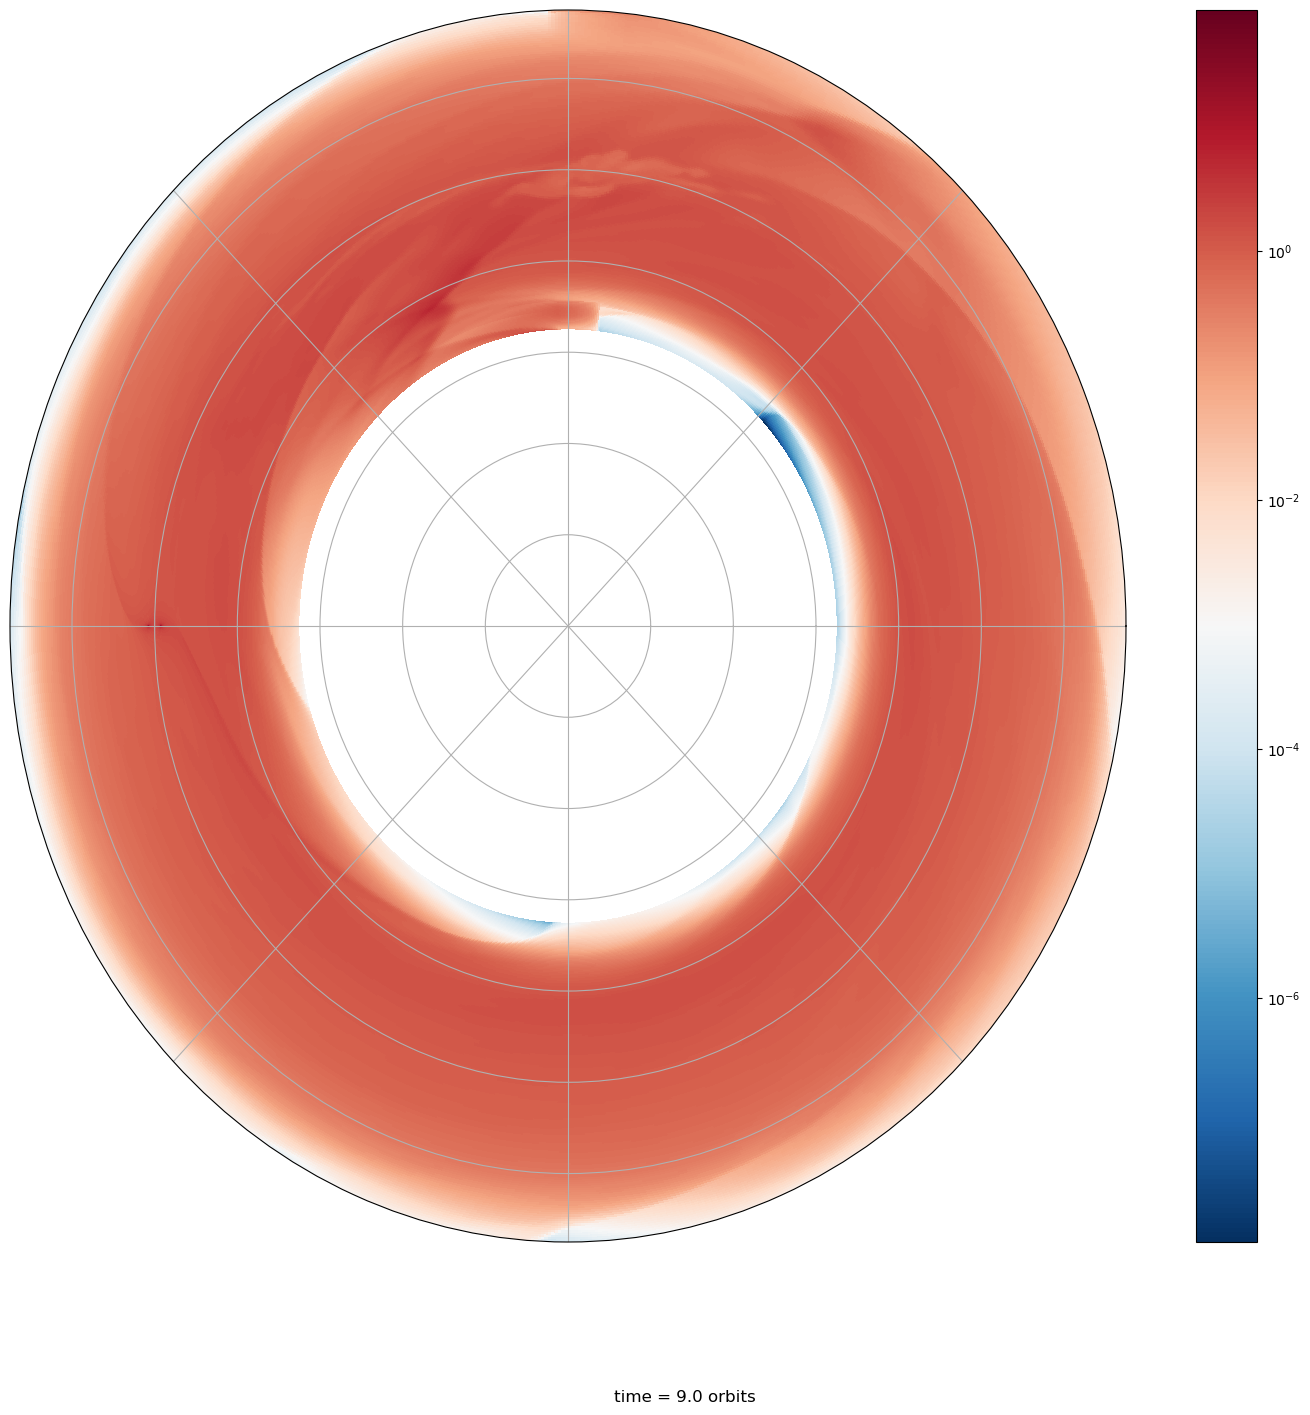

In [8]:
plots, axes = plt.subplots(figsize=(18,16),subplot_kw=dict(projection='polar'))

minval=min(data_midplane['vel3'][0])
maxval=max(data_midplane['vel3'][0])
# ridx = np.where(data['x1f'])[0][:-1]
# thetaidx = np.where(data['x2f'])[0][:-1]

norm=matplotlib.colors.LogNorm()
xmesh,ymesh=np.meshgrid(data_midplane['x3f'],data_midplane['x1f'])
im=axes.pcolormesh(xmesh,ymesh,data_midplane['rho'].T,cmap='RdBu_r', norm=norm)     

cbar=plots.colorbar(im, ax=axes)
# Turn off tick labels
axes.set_yticklabels([])
axes.set_xticklabels([])

plt.figtext(0.5, 0.01, 'time = '+str(data_midplane['Time'] // (2*np.pi)) + ' orbits', ha="center", fontsize=12)
# plt.title('Zoomed-in density, r and theta')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [9]:
q = 3e-5
Rh=(q/3)**(1/3)

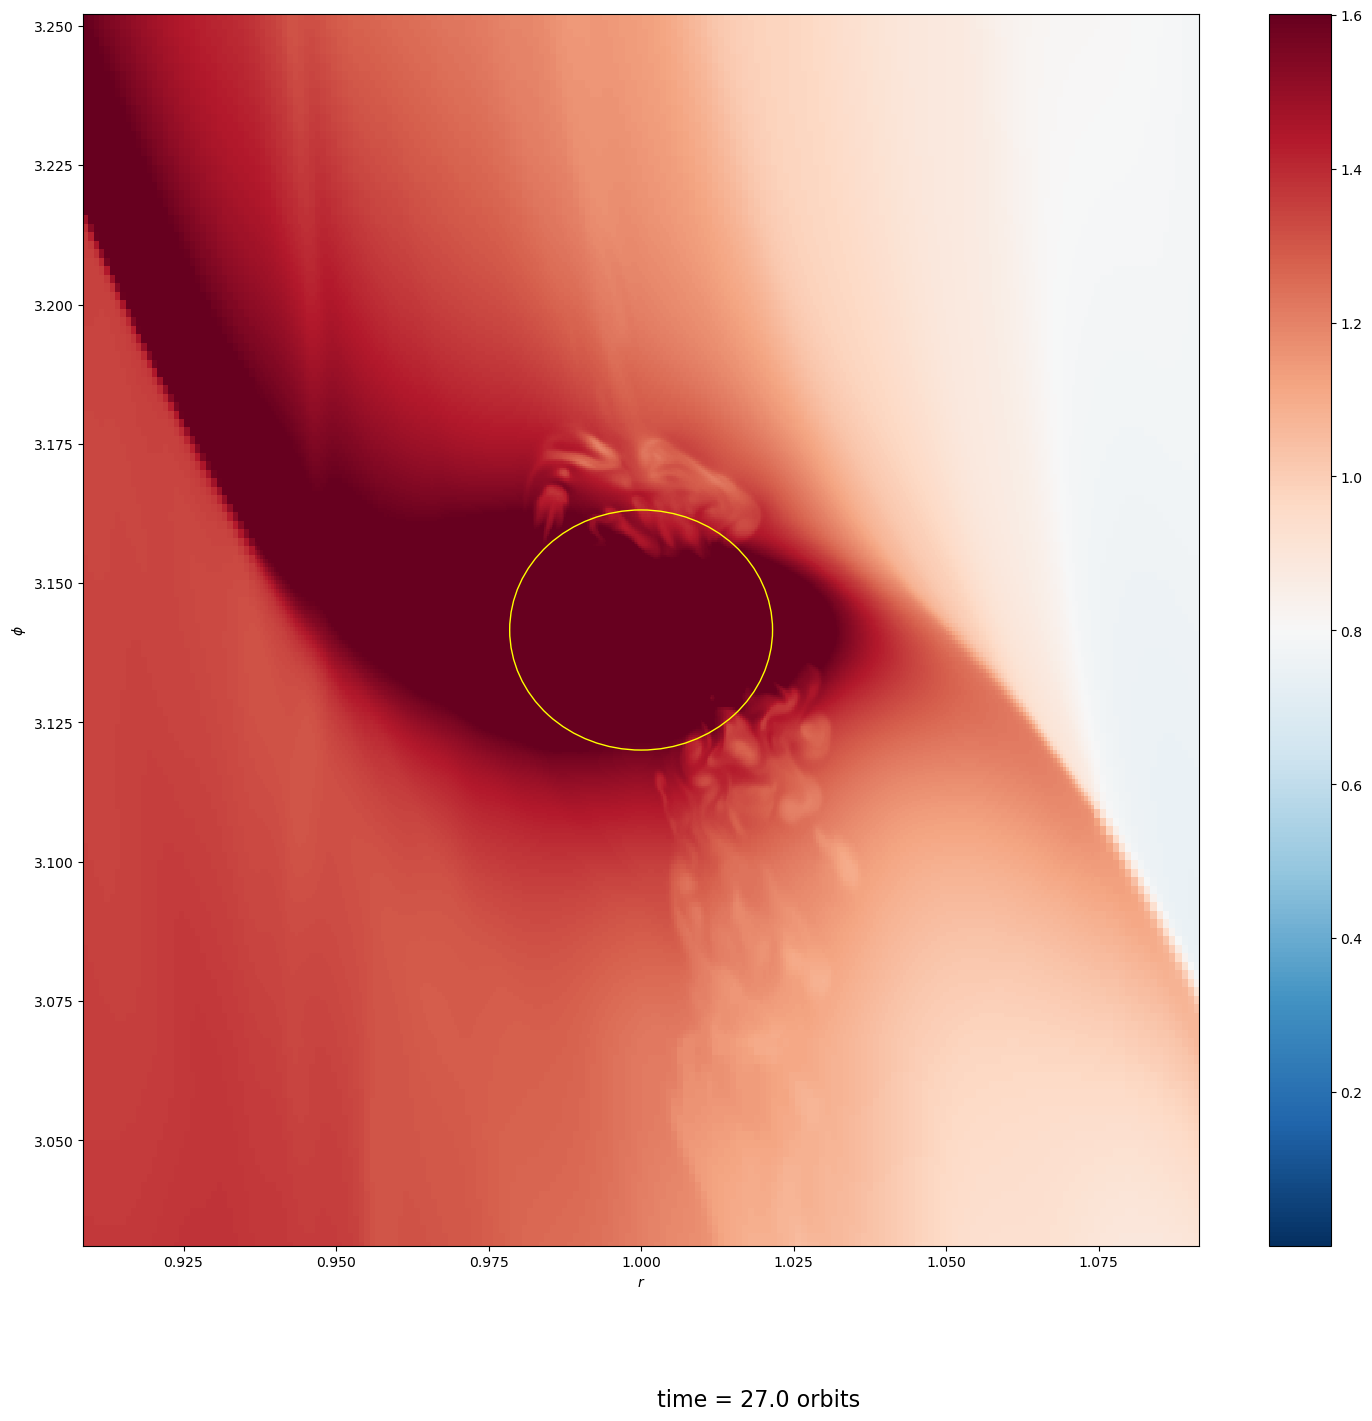

In [10]:
plots, axes = plt.subplots(figsize=(18,16))

minval=min(data_midplane['vel3'][0])
maxval=max(data_midplane['vel3'][0])
ridx = np.where((data_midplane['x1f']>1-(Rh)-0.07) & (data_midplane['x1f']<1+(Rh)+0.07))[0]
phiidx = np.where((data_midplane['x3f']>3.131120678077827-0.1) & (data_midplane['x3f']<3.152064629101759+0.1))[0]

norm=matplotlib.colors.Normalize(vmin=min(data_midplane['rho'][0]), vmax=max(data_midplane['rho'][0]))
xmesh,ymesh=np.meshgrid(data_midplane['x1f'][ridx],data_midplane['x3f'][phiidx])
im=axes.pcolormesh(xmesh,ymesh,data_midplane['rho'][phiidx][:,ridx],cmap='RdBu_r', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 30
ratey = 5

U = data_midplane['vel1'][phiidx][:,ridx]#[::ratex][:,::ratey]
V = data_midplane['vel3'][phiidx][:,ridx]#[::ratex][:,::ratey]
# U = data_midplane['vel1']#[::ratex][:,::ratey]
# V = data_midplane['vel3']#[::ratex][:,::ratey]
# print(U.shape)

x = np.linspace(data_midplane['x1f'][ridx][0], data_midplane['x1f'][ridx][-1],U.shape[1])#[::ratex]
y = np.linspace(data_midplane['x3f'][phiidx][0], data_midplane['x3f'][phiidx][-1],U.shape[0])#[::ratey]
# x = np.linspace(data_midplane['x1f'][0], data_midplane['x1f'][-1],U.shape[1])#[::ratex]
# y = np.linspace(data_midplane['x3f'][0], data_midplane['x3f'][-1],U.shape[0])#[::ratey]

X,Y = np.meshgrid(x,y)
#  Varying density along a streamline
# plt.streamplot(X,Y, U, V, color="green",density=4)
# plt.quiver(X,Y,U,V,color='green')

circle=plt.Circle((1,np.pi), Rh, color='yellow', fill=False)
axes.add_patch(circle)

plt.figtext(0.5, 0.01, 'time = '+str(data_midplane['Time'] // (2*np.pi) * 3) + ' orbits', ha="center", fontsize=16)
# plt.title('Zoomed-in density, r and theta')
plt.xlabel('$r$')
plt.ylabel('$\\phi$')
# axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

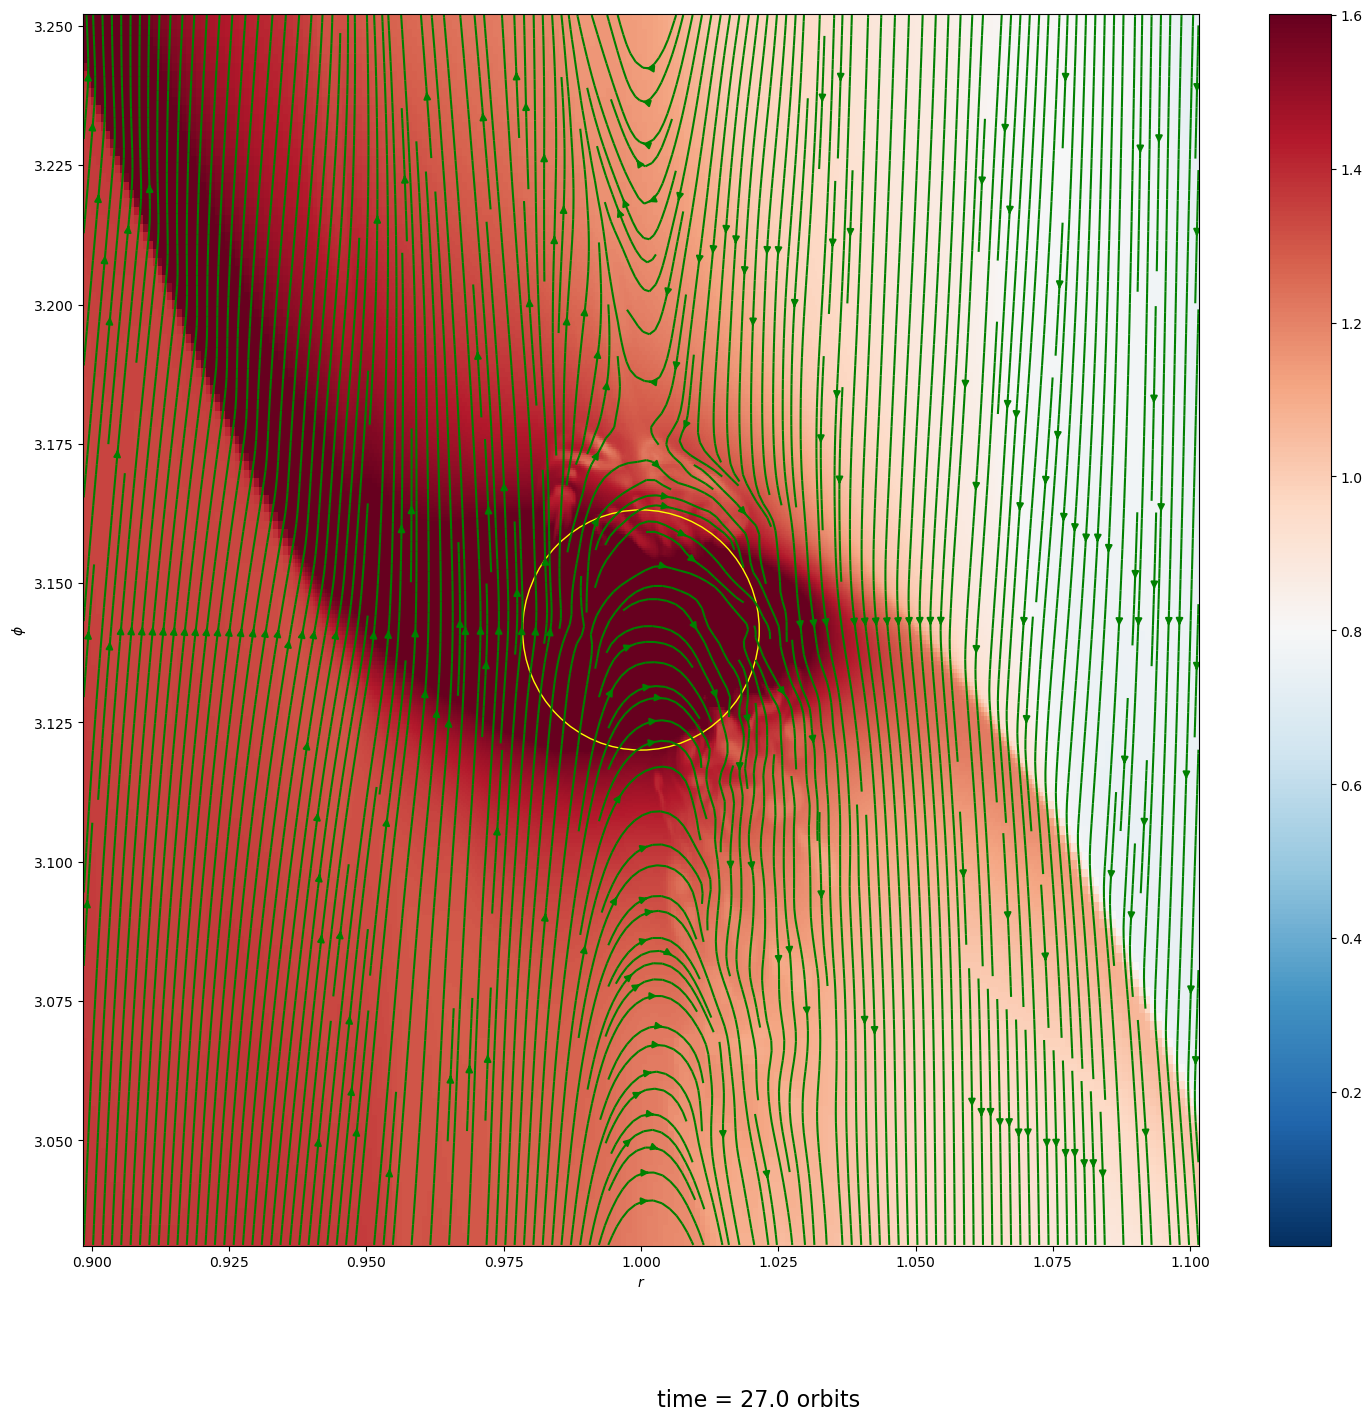

In [11]:
plots, axes = plt.subplots(figsize=(18,16))

minval=min(data_midplane['vel3'][0])
maxval=max(data_midplane['vel3'][0])
ridx = np.where((data_midplane['x1f']>1-(Rh)-0.08) & (data_midplane['x1f']<1+(Rh)+0.08))[0]
phiidx = np.where((data_midplane['x3f']>3.131120678077827-0.1) & (data_midplane['x3f']<3.152064629101759+0.1))[0]

norm=matplotlib.colors.Normalize(vmin=min(data_midplane['rho'][0]), vmax=max(data_midplane['rho'][0]))
xmesh,ymesh=np.meshgrid(data_midplane['x1f'][ridx],data_midplane['x3f'][phiidx])
im=axes.pcolormesh(xmesh,ymesh,data_midplane['rho'][phiidx][:,ridx],cmap='RdBu_r', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 60
ratey = 20

U = data_midplane['vel1'][phiidx][:,ridx]#[::ratex][:,::ratey]
V = data_midplane['vel3'][phiidx][:,ridx]#[::ratex][:,::ratey]
# U = data_midplane['vel1']#[::ratex][:,::ratey]
# V = data_midplane['vel3']#[::ratex][:,::ratey]
# print(U.shape)

x = np.linspace(data_midplane['x1f'][ridx][0], data_midplane['x1f'][ridx][-1],U.shape[1])#[::ratex]
y = np.linspace(data_midplane['x3f'][phiidx][0], data_midplane['x3f'][phiidx][-1],U.shape[0])#[::ratey]
# x = np.linspace(data_midplane['x1f'][0], data_midplane['x1f'][-1],U.shape[1])#[::ratex]
# y = np.linspace(data_midplane['x3f'][0], data_midplane['x3f'][-1],U.shape[0])#[::ratey]

X,Y = np.meshgrid(x,y)
#  Varying density along a streamline
plt.streamplot(X,Y, U, V, color="green",density=4)
# plt.quiver(X,Y,U,V,color='green')

circle=plt.Circle((1,np.pi), Rh, color='yellow', fill=False)
axes.add_patch(circle)

plt.figtext(0.5, 0.01, 'time = '+str(data_midplane['Time'] // (2*np.pi) * 3) + ' orbits', ha="center", fontsize=16)
# plt.title('Zoomed-in density, r and theta')
plt.xlabel('$r$')
plt.ylabel('$\\phi$')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

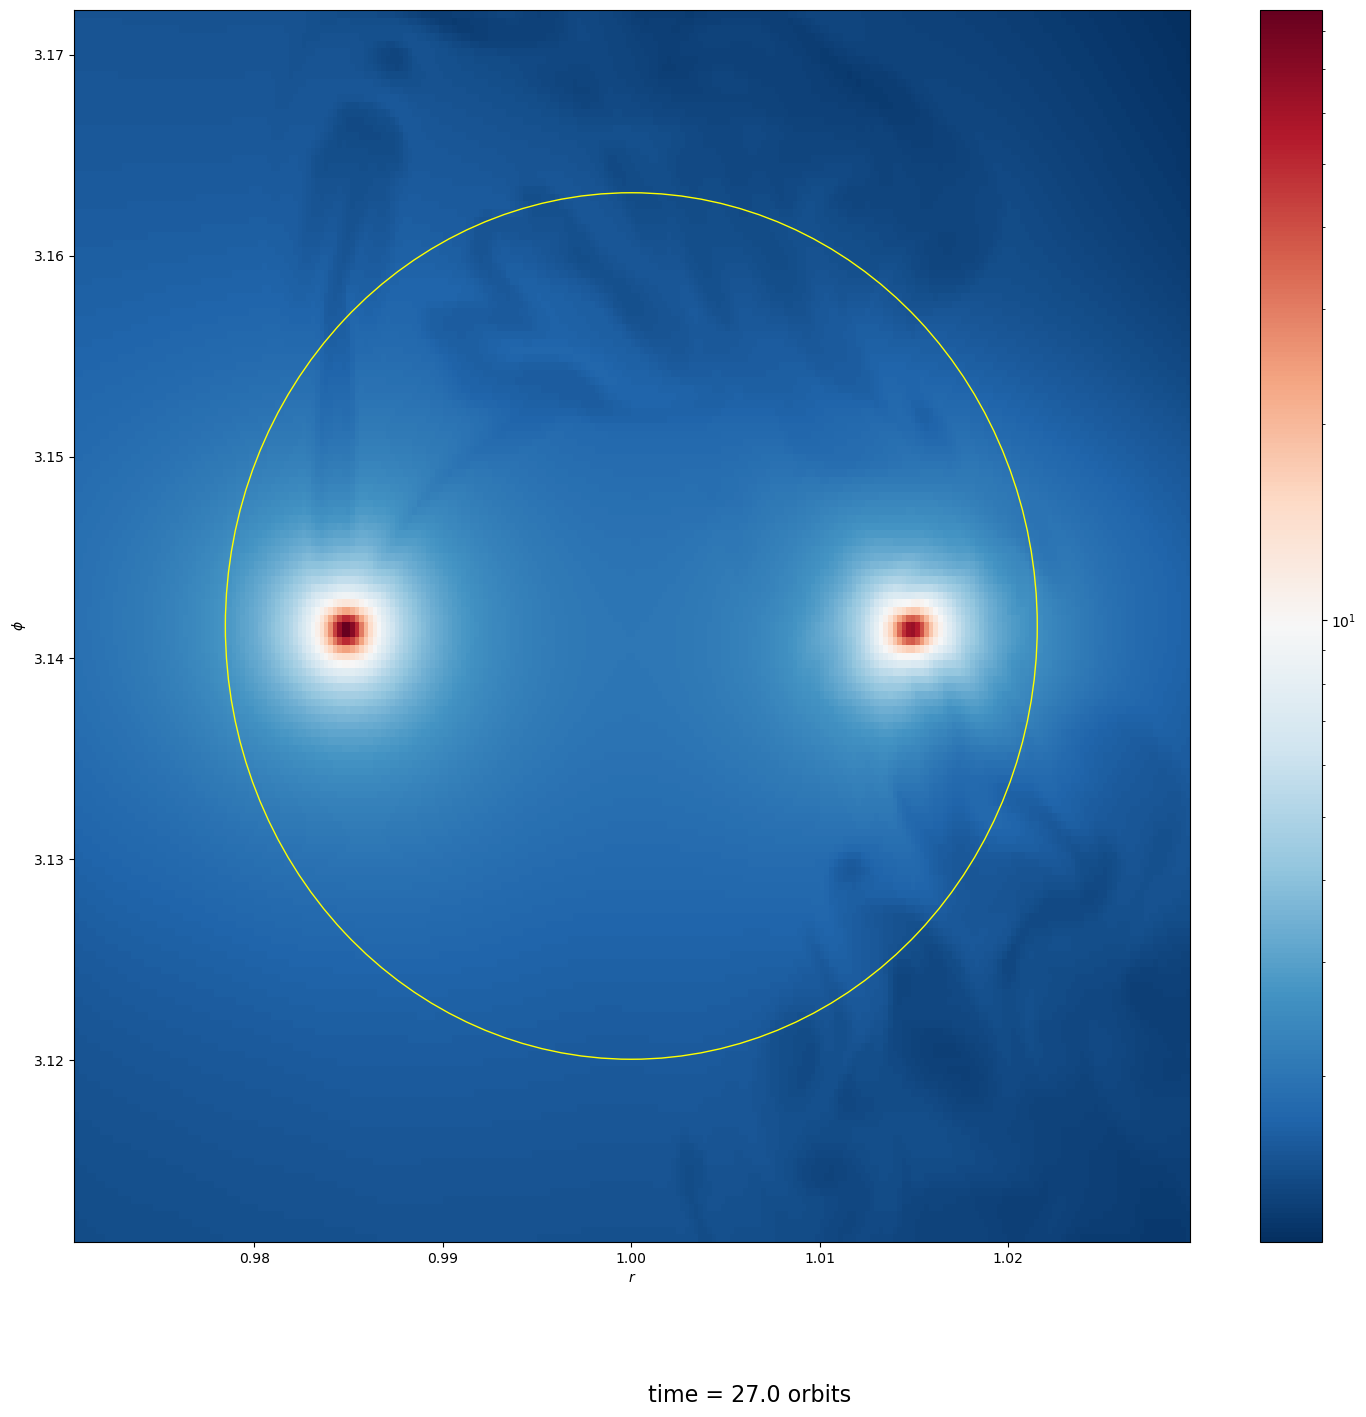

In [13]:
plots, axes = plt.subplots(figsize=(18,16))

minval=min(data_midplane['vel3'][0])
maxval=max(data_midplane['vel3'][0])
ridx = np.where((data_midplane['x1f']>1-(Rh)-0.008) & (data_midplane['x1f']<1+(Rh)+0.008))[0]
phiidx = np.where((data_midplane['x3f']>3.131120678077827-0.02) & (data_midplane['x3f']<3.152064629101759+0.02))[0]

norm=matplotlib.colors.LogNorm()
xmesh,ymesh=np.meshgrid(data_midplane['x1f'][ridx],data_midplane['x3f'][phiidx])
im=axes.pcolormesh(xmesh,ymesh,data_midplane['rho'][phiidx][:,ridx],cmap='RdBu_r', norm=norm)     

cbar=plots.colorbar(im, ax=axes)

ratex = 60
ratey = 20

U = data_midplane['vel1'][phiidx][:,ridx]#[::ratex][:,::ratey]
V = data_midplane['vel3'][phiidx][:,ridx]#[::ratex][:,::ratey]
# U = data_midplane['vel1']#[::ratex][:,::ratey]
# V = data_midplane['vel3']#[::ratex][:,::ratey]
# print(U.shape)

x = np.linspace(data_midplane['x1f'][ridx][0], data_midplane['x1f'][ridx][-1],U.shape[1])#[::ratex]
y = np.linspace(data_midplane['x3f'][phiidx][0], data_midplane['x3f'][phiidx][-1],U.shape[0])#[::ratey]
# x = np.linspace(data_midplane['x1f'][0], data_midplane['x1f'][-1],U.shape[1])#[::ratex]
# y = np.linspace(data_midplane['x3f'][0], data_midplane['x3f'][-1],U.shape[0])#[::ratey]

X,Y = np.meshgrid(x,y)
#  Varying density along a streamline
# plt.streamplot(X,Y, U, V, color="green",density=2)
# plt.quiver(X,Y,U,V,color='green')

circle=plt.Circle((1,np.pi), Rh, color='yellow', fill=False)
axes.add_patch(circle)

plt.figtext(0.5, 0.01, 'time = '+str(data_midplane['Time'] // (2*np.pi) * 3) + ' orbits', ha="center", fontsize=16)
# plt.title('Zoomed-in density, r and theta')
plt.xlabel('$r$')
plt.ylabel('$\\phi$')
axes.set_aspect('auto')
#plt.style.use('dark_background')
plt.show()

In [27]:
X.shape

(475, 857)

In [14]:
def AzCut(filename):
# Read attributes and data
  f=h5py.File(filename, 'r')
  level = f.attrs['MaxLevel']
  block_size = f.attrs['MeshBlockSize']
  root_grid_size = f.attrs['RootGridSize']
  levels = f['Levels'][:]
  logical_locations = f['LogicalLocations'][:]
  nx1 = root_grid_size[0] * 2**level
  nx2 = root_grid_size[1] * 2**level if root_grid_size[1] > 1 else 1
  nx3 = root_grid_size[2] * 2**level if root_grid_size[2] > 1 else 1

  if nx3 > 1:
    dim = 3
  elif nx2 > 1:
    dim = 2
  else:
    dim = 1

  data={}

# the coordinates
  for d in range(1,4):
    nx = (nx1,nx2,nx3)[d-1]
    xmin = f.attrs['RootGridX'+repr(d)][0]
    xmax = f.attrs['RootGridX'+repr(d)][1]
    xrat_root = f.attrs['RootGridX'+repr(d)][2]
    if (xrat_root == 1.0):
      data['x'+repr(d)+'f'] = np.linspace(xmin, xmax, nx+1)
    else:
      xrat = xrat_root ** (1.0 / 2**level)
      data['x'+repr(d)+'f'] = \
         xmin + (1.0-xrat**np.arange(nx+1)) / (1.0-xrat**nx) * (xmax-xmin)


  var_quantities = np.array([x.decode('ascii', 'replace') for x in f.attrs['VariableNames'][:]])
  coord_quantities = ('x1f', 'x2f', 'x3f', 'x1v', 'x2v', 'x3v')
  attr_quantities = [key for key in f.attrs]
  other_quantities = ('Levels',)    
  quantities = var_quantities
  quantities = [str(q) for q in quantities if q not in coord_quantities 
              and q not in attr_quantities and q not in other_quantities]
  for key in attr_quantities:
    data[str(key)] = f.attrs[key]
  num_blocks = f.attrs['NumMeshBlocks']
  dataset_names = np.array([x.decode('ascii', 'replace')
                                  for x in f.attrs['DatasetNames'][:]])
  dataset_sizes = f.attrs['NumVariables'][:]
  dataset_sizes_cumulative = np.cumsum(dataset_sizes)
  variable_names = np.array([x.decode('ascii', 'replace')
                                   for x in f.attrs['VariableNames'][:]])
  quantity_datasets = []
  quantity_indices = []
  spec_datasets = []
  spec_indices = []
  for q in quantities:
    var_num = np.where(variable_names == q)[0][0]
    dataset_num = np.where(dataset_sizes_cumulative > var_num)[0][0]
    if dataset_num == 0:
          dataset_index = var_num
    else:
          dataset_index = var_num - dataset_sizes_cumulative[dataset_num-1]
    quantity_datasets.append(dataset_names[dataset_num])
    quantity_indices.append(dataset_index)
    if q == 'rho' or q=='vel1' or q=='vel2' or q=='vel3' or q=='press' or q=='Bcc1' or \
                q=='Bcc2' or q=='Bcc3' or q=='Er' or q=='Sigma_s_0' or q=='Sigma_a_0' or q=='Fr01' or q=='Fr02' \
                or q == 'Fr03' or q == 'Er0':
      spec_datasets.append(dataset_names[dataset_num])
      spec_indices.append(dataset_index)



# get rho, v1, v2, v3, B1, B2, B3, kappa_s, kappa_a


  n_rmax=nx1
  for q in quantities:
    data[q] = np.zeros((nx2,n_rmax))
  vol_phi=np.zeros((nx2,n_rmax))


# Go through blocks in data file
  for block_num in range(num_blocks):
    # Extract location information
    block_level = levels[block_num]
    block_location = logical_locations[block_num,:]
   # Calculate scale (number of copies per dimension)
    s= 2**(level-block_level)
  
  # the block size
    block_phi_size=f['x3f'][block_num][block_size[2]]-f['x3f'][block_num][0]
    radius=f['x1f'][block_num]
    theta=f['x2f'][block_num]
    phi=f['x3f'][block_num]



# get cell center coordinates
    x1v=np.zeros(block_size[0])
    x2v=np.zeros(block_size[1])
    x3v=np.zeros(block_size[2])
  
    for ni in range(block_size[0]):
      x1v[ni]=0.75*(radius[ni+1]**4.0 - radius[ni]**4.0)/(radius[ni+1]**3.0-radius[ni]**3.0);
  
    for nj in range(block_size[1]):
      x2v[nj]=((np.sin(theta[nj+1]) - theta[nj+1] * np.cos(theta[nj+1])) \
            -(np.sin(theta[nj]) - theta[nj] * np.cos(theta[nj]))) \
              / (np.cos(theta[nj]) - np.cos(theta[nj+1]));

    for nk in range(block_size[2]):
      x3v[nk] = 0.5 * (phi[nk+1]+phi[nk])
  
    grid_phi,grid_theta,grid_r=np.meshgrid(x3v,x2v,x1v,indexing='ij')
  

# Calculate fine-level begin indices
    il = block_location[0] * block_size[0] * s
    jl = block_location[1] * block_size[1] * s if dim >= 2 else 0

# Calculate fine-level end indices
    iu = il + block_size[0] * s
    ju = jl + block_size[1] * s if dim >= 2 else 1

# Calculate fine-level offsets
    io_vals = range(s)
    jo_vals = range(s) if dim >= 2 else (0,)


    
    

  

    for jo in jo_vals:
      for io in io_vals:
          vol_phi[jl+jo:ju+jo:s,il+io:iu+io:s] \
              = vol_phi[jl+jo:ju+jo:s,il+io:iu+io:s] + block_phi_size


  # Assign values
    for q,dataset,index in zip(quantities,quantity_datasets,quantity_indices):
      oridata=f[dataset][index,block_num,:]

        
      for jo in jo_vals:
        for io in io_vals:
          data[q][jl+jo:ju+jo:s,il+io:iu+io:s] \
                   = data[q][jl+jo:ju+jo:s,il+io:iu+io:s] + \
                     block_phi_size * np.mean(oridata,axis=0)
        


# divide by the total phi volume

  for q in quantities:
      data[q][:,:] = data[q][:,:]/vol_phi[:,:]
      data[q][:,:] = np.nan_to_num(data[q][:,:])


# get the cell center coordinates
  # get cell center coordinates
  data['x1v']=np.zeros(nx1)
  data['x2v']=np.zeros(nx2)
  
  for ni in range(nx1):
    data['x1v'][ni]=0.75*(data['x1f'][ni+1]**4.0 - data['x1f'][ni]**4.0)/(data['x1f'][ni+1]**3.0-data['x1f'][ni]**3.0);
  
  for nj in range(nx2):
    data['x2v'][nj]=((np.sin(data['x2f'][nj+1]) - data['x2f'][nj+1] * np.cos(data['x2f'][nj+1])) \
           -(np.sin(data['x2f'][nj]) - data['x2f'][nj] * np.cos(data['x2f'][nj]))) \
              / (np.cos(data['x2f'][nj]) - np.cos(data['x2f'][nj+1]));

  #add time
  data['Time']=f.attrs['Time']
  data['quantities']=quantities
  f.close()

  return data


In [16]:
fname2='disk.hst'

In [55]:
colnames = [
    '[1]=time', '[2]=dt','[3]=mass','[4]=1-mom', '[5]=2-mom','[6]=3-mom','[7]=1-KE','[8]=2-KE','[9]=3-KE','[10]=tot-E', '[11]=fr1','[12]=ft1','[13]=fp1',
    '[14]=fr2','[15]=ft2','[16]=fp2','[17]=fxpp1','[18]=fypp1','[19]=fzpp1','[20]=fxpp2','[21]=fypp2','[22]=fzpp2','[23]=torque1', '[24]=torque2', 
    '[25]=xpp1', '[26]=ypp1', '[27]=zpp1','[28]=xpp2','[29]=ypp2','[30]=zpp2', '[31]=rpp1','[32]=tpp1', '[33]=ppp1','[34]=rpp2','[35]=tpp2','[36]=ppp2','[37]=mp1',
    '[38]=mp2','[39]=Eb1','[40]=Eb2','[41]=vol','[42]=vp1','[43]=vp2','[44]=mass_sink1'
]

In [106]:
np.genfromtxt(fname2,usecols=(37))/17

array([1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05,
       1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05,
       1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05,
       1.5e-05, 1.5e-05, 1.5e-05, 1.5e-05])

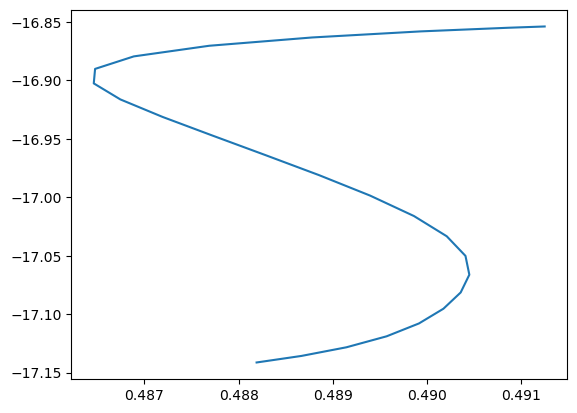

In [111]:
plt.plot(np.genfromtxt(fname2,usecols=(2)),np.genfromtxt(fname2,usecols=(24)))